In [1]:
import torch
import torchvision
import pandas as pd
import sys
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
device = "mps"

### Data import

In [2]:
df = pd.read_csv('/Users/alessandrobreccia/data/MNIST/mnist_train.csv')
labels = df['label']
df = df.drop('label', axis=1)
df = df.sample(n=10000, random_state=123).reset_index(drop=True)
labels = labels.sample(n=10000, random_state=123).reset_index(drop=True)

In [3]:
data = torch.tensor(df.values)/255.0*2 - 1
data = data.view(-1, 1, 28, 28).to(device)
data = F.pad(data, (2, 2, 2, 2), mode='constant', value=-1)
y = torch.tensor(labels.values).view(-1, 1)
y = F.one_hot(y, num_classes=10) 

In [4]:
IS = data.shape[-1]

In [5]:
def plot_img(X,t):
    plt.figure(figsize = (16, 6))
    for i in range(len(t)):
        plt.subplot(1, len(t), i+1)
        plt.imshow(X[i][0].cpu(), cmap = 'gray')
        plt.axis('off')
    plt.show()

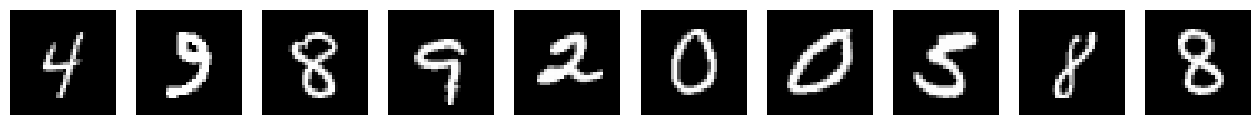

In [6]:
plot_img(data, torch.randint(0, 100, (10,)))

In [7]:
T = 200
cosine_sched = True

def cos_sched(t, eps = 1E-6):
    return torch.cos( (t/T+eps)/(1+eps)*torch.pi/2)**2

if not cosine_sched:
    b = torch.linspace(0.00001,0.04,T).to(device)
    a = 1.0 - b
    a_bar = a.cumprod(dim=0).to(device)
    a_prev = F.pad(a_bar[:-1], (1, 0), value=1.0)
    var = b*(1-a_prev)/(1-a_bar)
    
else:
    t_lin = torch.linspace(0,T-1,T).to(device)
    a_bar = cos_sched(t_lin)/cos_sched(torch.tensor([0])).to(device) -1E-6
    a_prev = F.pad(a_bar[:-1], (1, 0), value=1.0)
    b = 1 - a_bar/a_prev
    a = 1.0 - b
    var = b*(1-a_prev)/(1-a_bar)

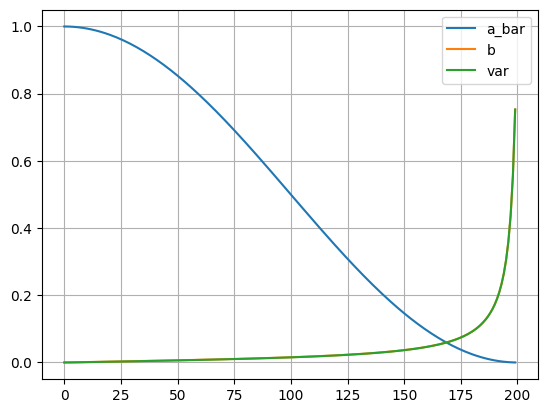

beta range: [0.00000101, 0.75304204]


In [8]:
plt.plot(a_bar.cpu(), label='a_bar')
plt.plot(b.cpu(), label='b')
plt.plot(var.cpu(), label='var')
plt.grid()
plt.legend()
plt.show()
print('beta range: [{:.8f}, {:.8f}]'.format(b.min(), b.max()))

In [9]:
def noisy_img(X, t):
    noise = torch.randn_like(X, device=device)
    a_bar_t = a_bar[t].view(-1, 1, 1, 1)
    x_noise = a_bar_t**0.5*X.to(device) + (1-a_bar_t)**0.5*noise
    return  x_noise, noise

In [10]:
def plot_noise_schedule(X):
    plt.figure(figsize = (16, 6))
    for i,t in enumerate(torch.linspace(0,T-1,10)):
        plt.subplot(1, 10, i+1)
        x, _ = noisy_img(X,int(t))
        plt.imshow(x.view(IS,IS).cpu(), cmap='gray')
        plt.title(f't = {int(t)}')
        plt.axis('off')
    plt.show()

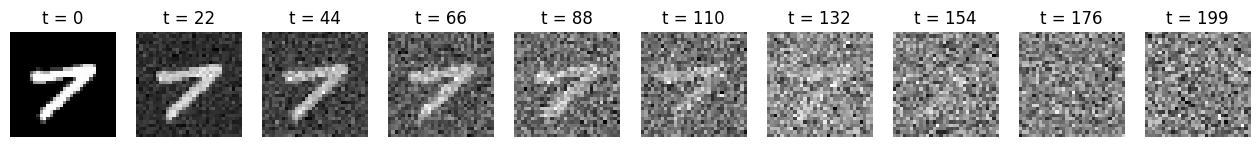

In [11]:
plot_noise_schedule(data[torch.randint(0,len(data), (1,))])

### Denoising Model

In [12]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        embeddings = math.log(self.dim*2) / (self.dim - 1)
        embeddings = torch.exp(torch.arange(half_dim) * -embeddings).to(device)
        embeddings = t[:, None].to(device) * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    
class Head(nn.Module):
    def __init__(self, n_emb, head_size, drop = 0):
        super().__init__()
        self.key = nn.Linear(n_emb, head_size, bias=False)
        self.query = nn.Linear(n_emb, head_size, bias=False)
        self.value = nn.Linear(n_emb, head_size, bias=False)
        self.drop = nn.Dropout(drop)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x) # (B,T, H)
        q = self.query(x) # (B, T, H)

        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B,T,H) @ (B, H, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1)
        wei = self.drop(wei)

        v = self.value(x) # (B, T, H)
        out = wei @ v # (B,T,T) @ (B, T, H) -> (B, T, H)
        return out

class MultiHeadAttention(nn.Module):

    def __init__(self, n_emb, head_size, num_heads, drop = 0):
        super().__init__()
        self.heads = nn.ModuleList( Head(n_emb, head_size, drop) for _ in range(num_heads) )
        self.proj = nn.Linear(head_size*num_heads, n_emb)
        self.drop = nn.Dropout(drop)
  
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.drop(out)
        out = self.proj(out)
        return out

class UBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, cond):
        super().__init__()

        self.cond = cond
        self.time = TimeEmbedding(time_emb_dim).to(device)
        self.time_emb = nn.Linear(time_emb_dim, out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.y_proj = nn.Linear(10, out_channels)

    def forward(self, x, y, t):
        # Time embedding 
        time = self.time(t.float())
        # Activation after projection
        time = self.relu(self.time_emb(time))
        # Adjust time embedding to the same shape as x
        time = time.unsqueeze(-1).unsqueeze(-1)
        # first convolution
        h = self.conv1(x)
        h = self.relu(h)
        h = self.batchnorm1(h)
        # Add time embedding
        if self.cond:
            yproj = self.relu(self.y_proj(y.float()))
            yproj = yproj.squeeze().unsqueeze(-1).unsqueeze(-1)
            h = h + time + yproj
        else:
            h = h + time
        # Second convolution
        h = self.conv2(h)
        h = self.relu(h)
        h = self.batchnorm2(h) 
        return h

class UNet(nn.Module):
    def __init__(self, cond):
        super().__init__()
        self.emb_dim = T
        self.channels = [1, 64, 128, 256, 512]
        #self.channels = [1, 16, 32, 64, 128, 256]

        self.pool = nn.MaxPool2d(2)

        self.down_blocks = nn.ModuleList([UBlock(self.channels[i-1], self.channels[i], self.emb_dim, cond) for i in range(1, len(self.channels))])
        self.up_blocks = nn.ModuleList([UBlock(self.channels[i], self.channels[i-1], self.emb_dim, cond) for i in range(len(self.channels)-1, 1, -1)])
        self.out = nn.Conv2d(self.channels[1], 1, 1).to(device)

        self.convT = [nn.ConvTranspose2d(self.channels[i], self.channels[i-1], 2, stride=2).to(device) for i in range(len(self.channels)-1, 1, -1)]

        self.mha = MultiHeadAttention(self.channels[-1], 8, 16, 0.05)
        self.act = nn.ReLU()
        #self.ln = nn.LayerNorm(self.channels[-1])

    def forward(self, x, y, t):
        downs = []
        x, y, t = x.to(device), y.to(device), t.to(device)

        for i in range(0, len(self.down_blocks)):
            x = self.down_blocks[i](x, y, t)
            downs.append(x)
            if i != len(self.down_blocks)-1:
                x = self.pool(x)
        
        x_shape = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = x + self.act(self.mha(x))
        x = x.transpose(1, 2).view(x_shape)  

        for i in range(len(self.up_blocks)):
            x = self.convT[i](x)
            x = torch.cat((x, downs[-(i+2)]), dim = 1)
            x = self.up_blocks[i](x, y, t)

        out = self.out(x)
        return out
  

In [13]:
model = UNet(False)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  7574401


UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_blocks): ModuleList(
    (0): UBlock(
      (time): TimeEmbedding()
      (time_emb): Linear(in_features=200, out_features=64, bias=True)
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (y_proj): Linear(in_features=10, out_features=64, bias=True)
    )
    (1): UBlock(
      (time): TimeEmbedding()
      (time_emb): Linear(in_features=200, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    

In [14]:
mus = []
@torch.no_grad()
def sample_at_time(model, x, y, t):

    cov = b[t].to(device)/(1-a_bar[t].to(device))**0.5
    noise = model(x, y, t)
    
    mu = 1/a[t].to(device)**0.5*(x-cov*noise)
    mus.append(mu.mean())
    var = b[t]*(1-a_bar[t-1])/(1-a_bar[t])

    if t == 0:
        return mu
    else:
        return mu + torch.randn_like(noise)*var**0.5

@torch.no_grad()
def sample(model, size=1, w=16, h=2, label=None ,histo=False):

    img_shape = (size, 1, IS, IS)
    if label == None:
        label = torch.randint(10, (1,)).item()
        
    label = torch.tensor(label).unsqueeze(0)
    y = F.one_hot(label, num_classes=10).repeat(size,1)
    img = torch.randn(img_shape).to(device)

    times = torch.arange(0,T-1,20)
    fig, ax = plt.subplots(size, len(times), figsize=(w,h*size))
    fig.suptitle(f'Label {label[0].item()}')
    j = 0

    for i in range(0,T)[::-1]:
        t = torch.tensor([i])
        img = sample_at_time(model, img, y, t)
        #img = img/img.max()
        img = torch.clamp(img, -1.0, 1.0)

        if i in times:
            if histo:
                plt.subplot(1, len(times), j)
                plt.title(f' m = {img.view(-1).mean():03f}')
                #plt.axis('off')
                counts, bins = torch.histogram(img.view(-1))
                plt.hist(bins[:-1], bins, weights=counts, density=True)
                plt.grid()
                
            else:
                for s in range(size):
                    ax[0,j].set_title(f't = {int(t.item())}')
                    ax[s,j].axis('off')
                    ax[s,j].imshow(img[s].detach().cpu().view(IS,IS), cmap='gray')
            j += 1

    plt.tight_layout()
    plt.show()
    

Epoch 0 | step 000 Loss: 0.8645075559616089 


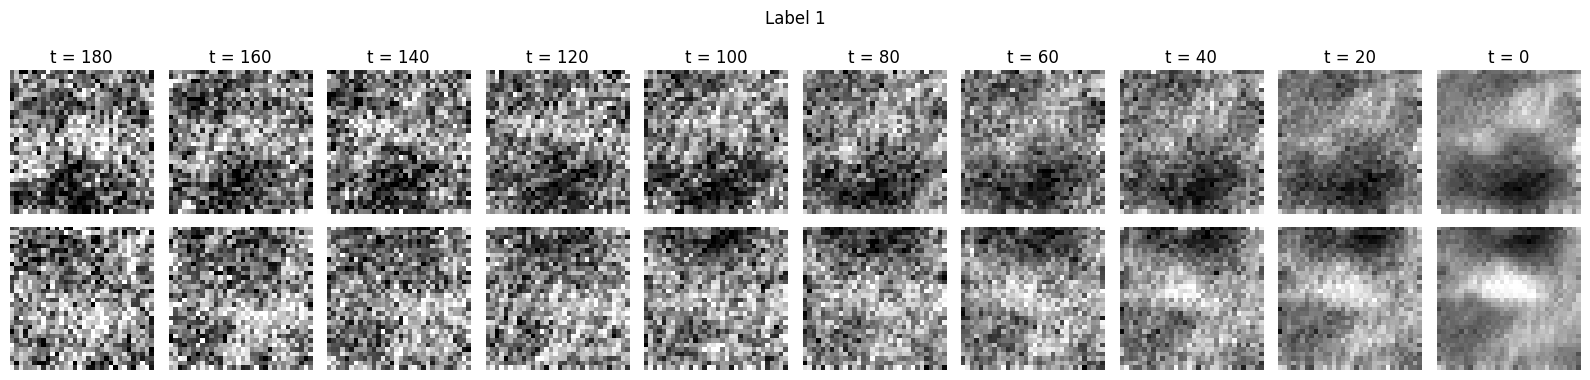

Epoch 1 | step 000 Loss: 0.1376250982284546 


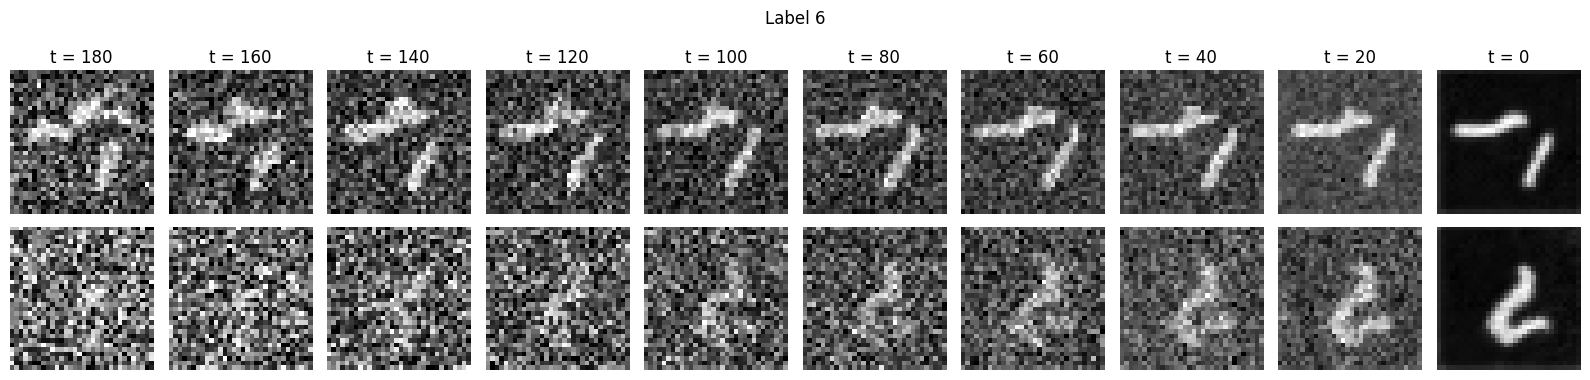

Epoch 2 | step 000 Loss: 0.11691224575042725 


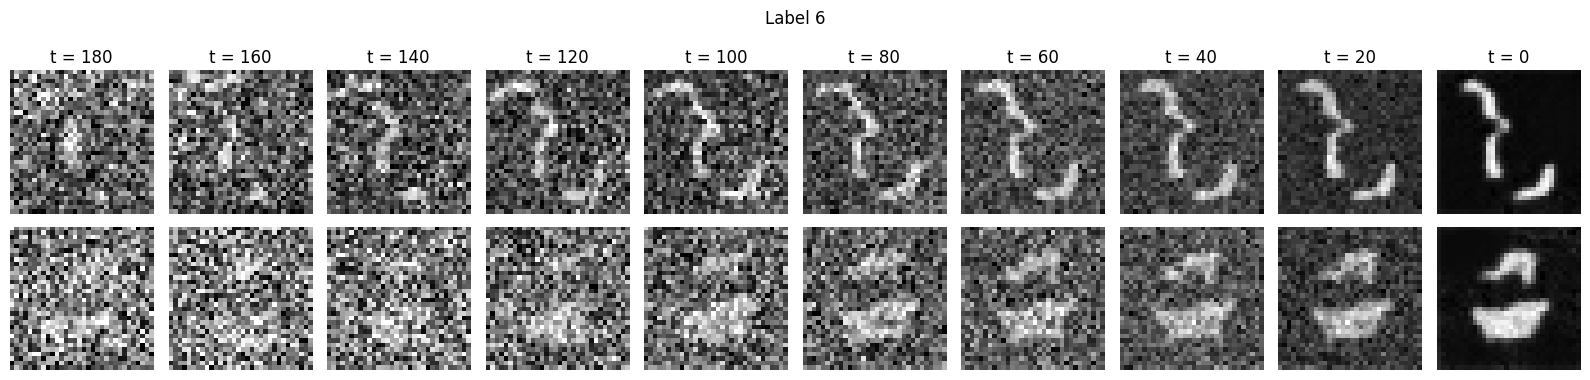

Epoch 3 | step 000 Loss: 0.08936886489391327 


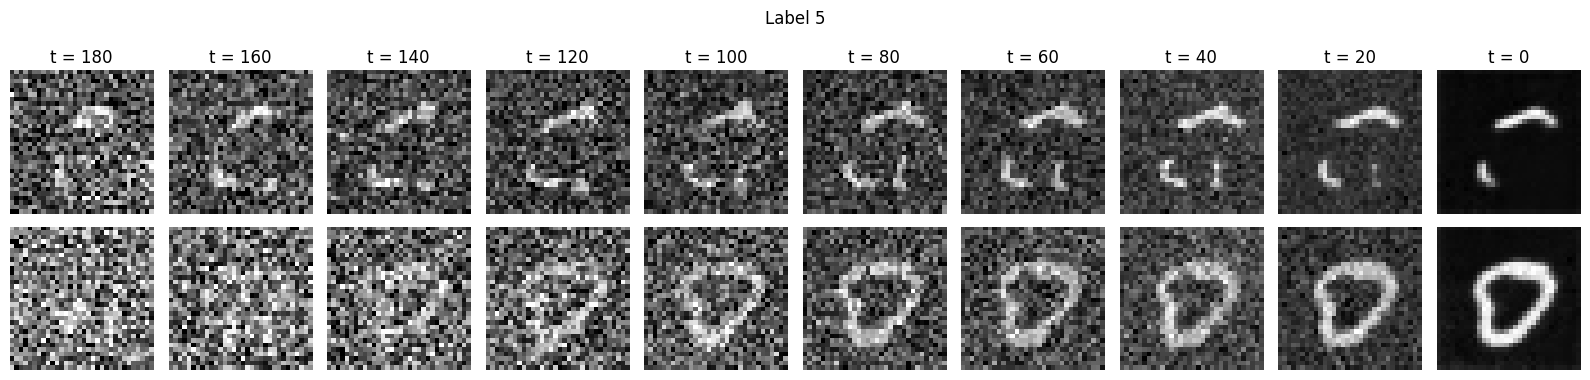

Epoch 4 | step 000 Loss: 0.08671553432941437 


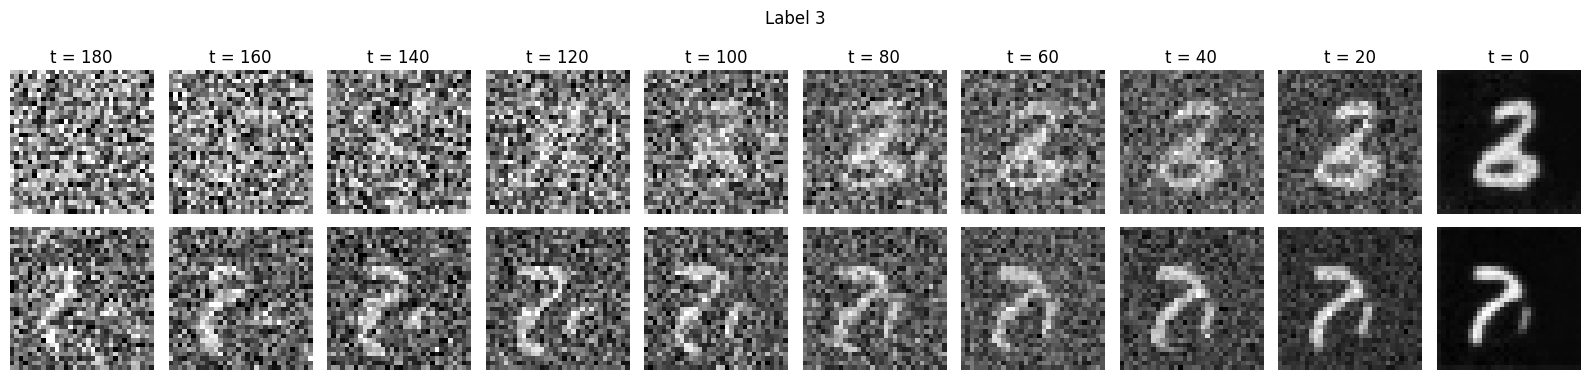

Epoch 5 | step 000 Loss: 0.08172403275966644 


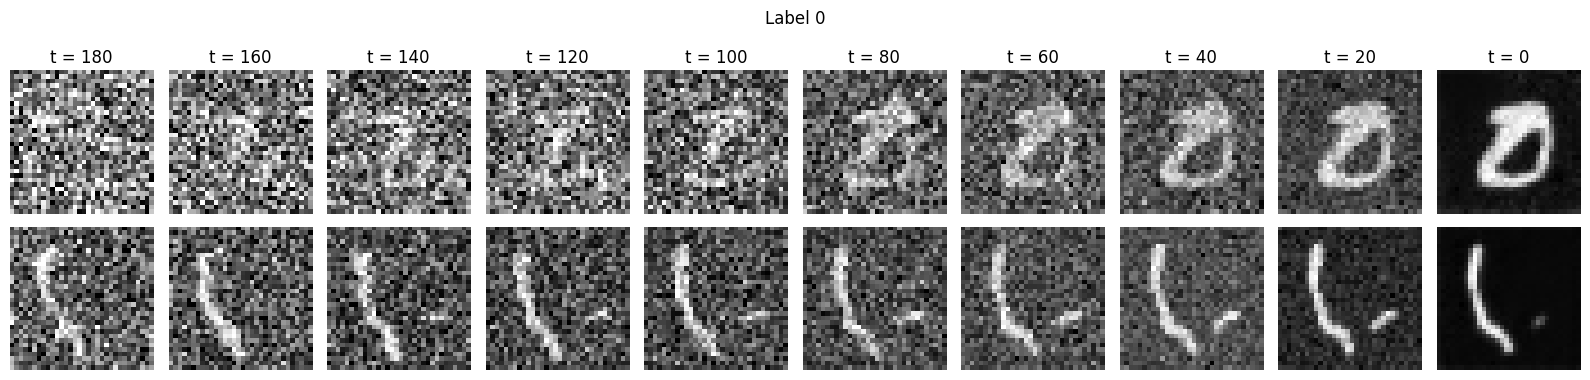

Epoch 6 | step 000 Loss: 0.08846915513277054 


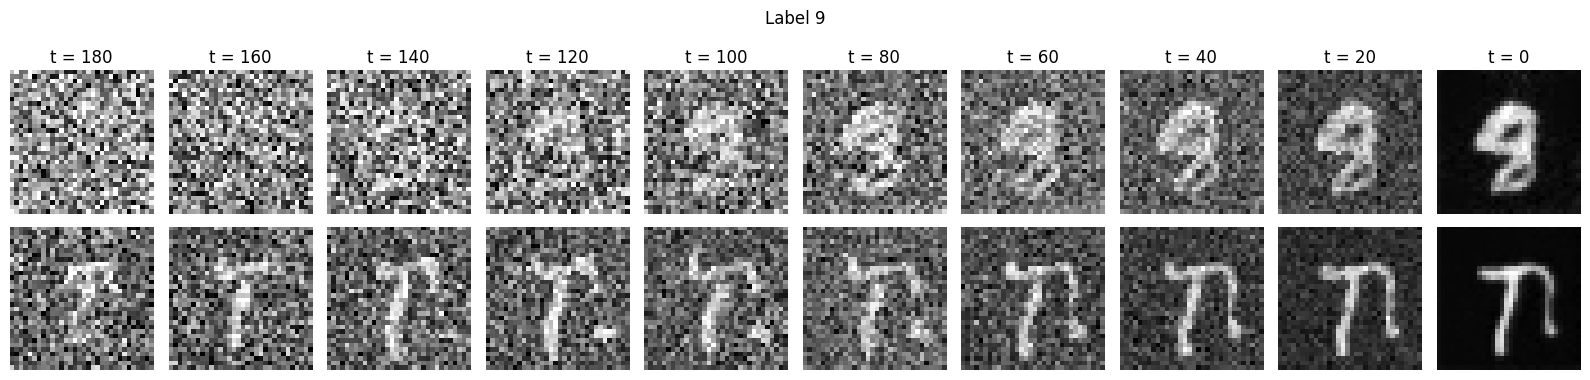

Epoch 7 | step 000 Loss: 0.07183575630187988 


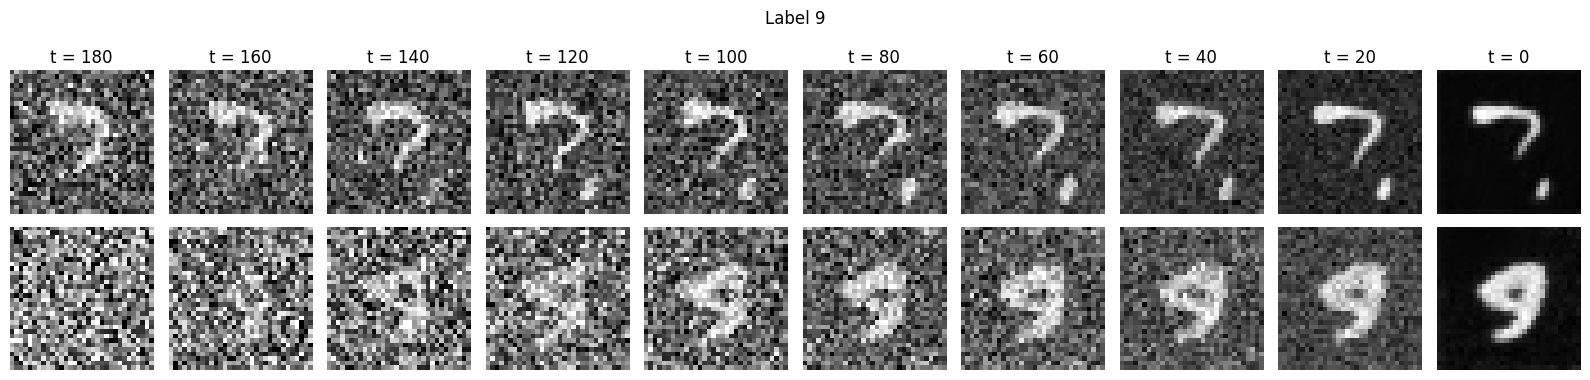

Epoch 8 | step 000 Loss: 0.07825775444507599 


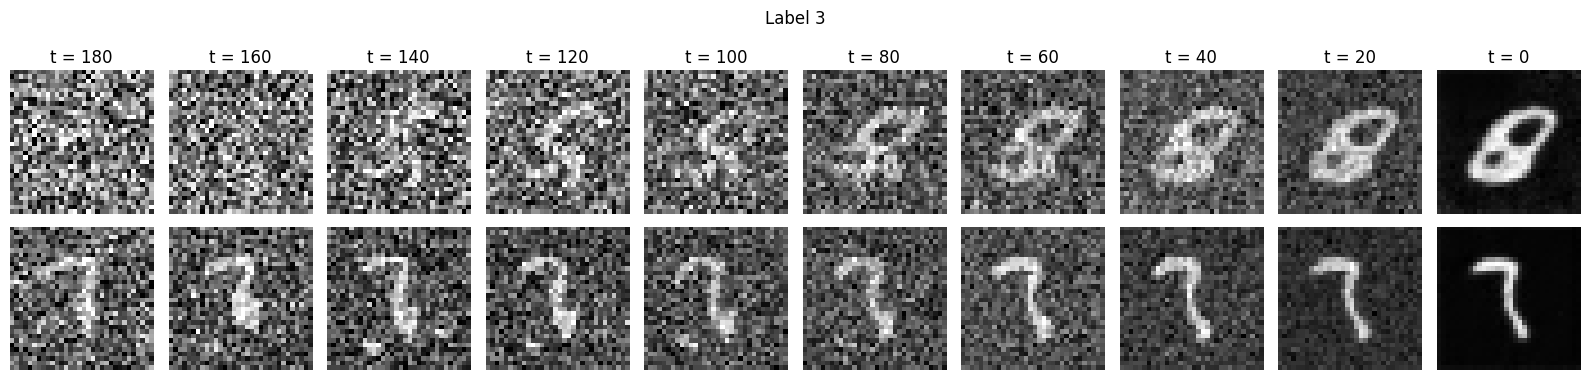

Epoch 9 | step 000 Loss: 0.07761486619710922 


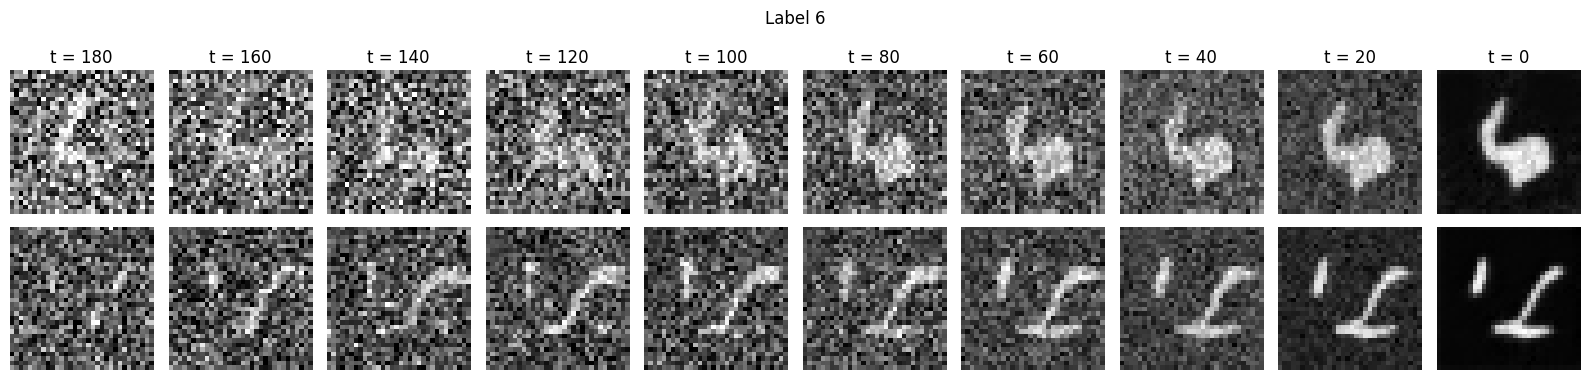

Epoch 10 | step 000 Loss: 0.07271794229745865 


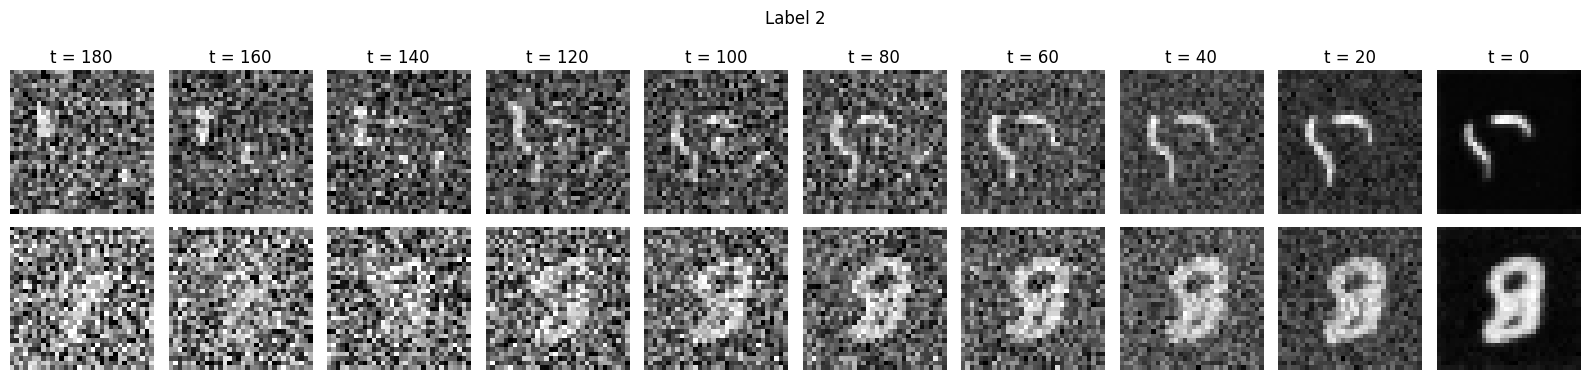

Epoch 11 | step 000 Loss: 0.0682314783334732 


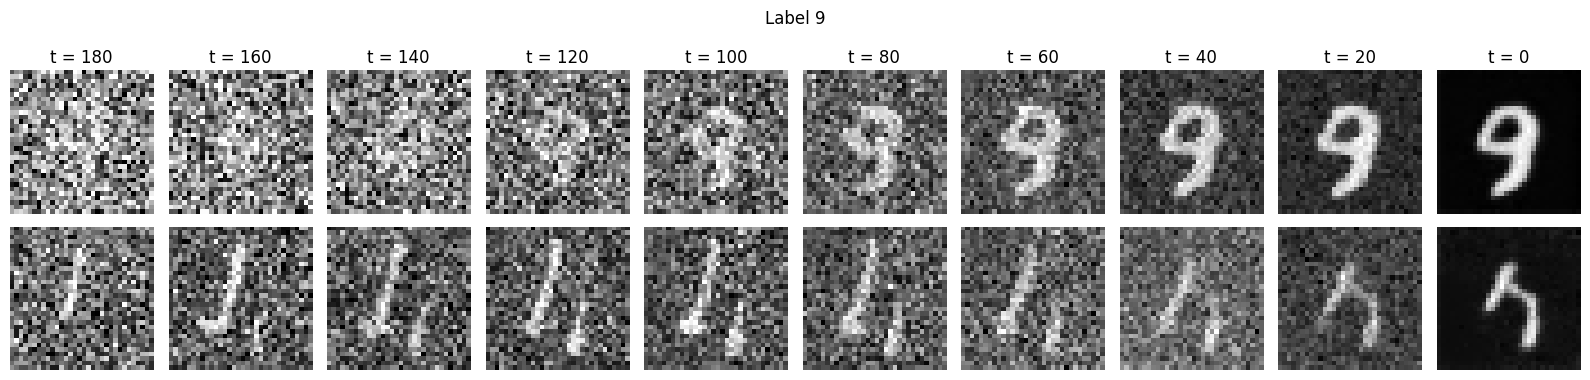

Epoch 12 | step 000 Loss: 0.0695771723985672 


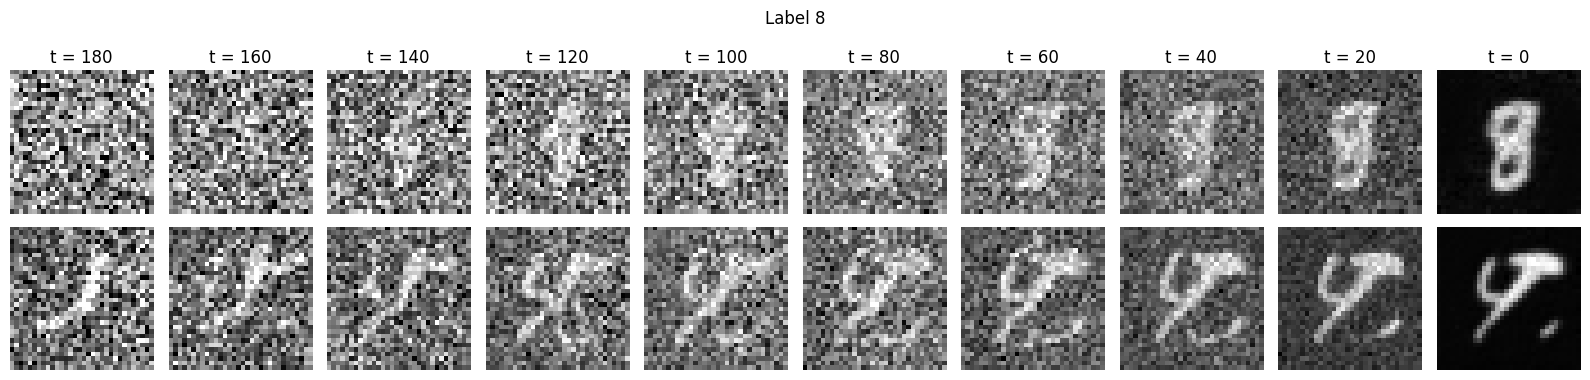

Epoch 13 | step 000 Loss: 0.09201960265636444 


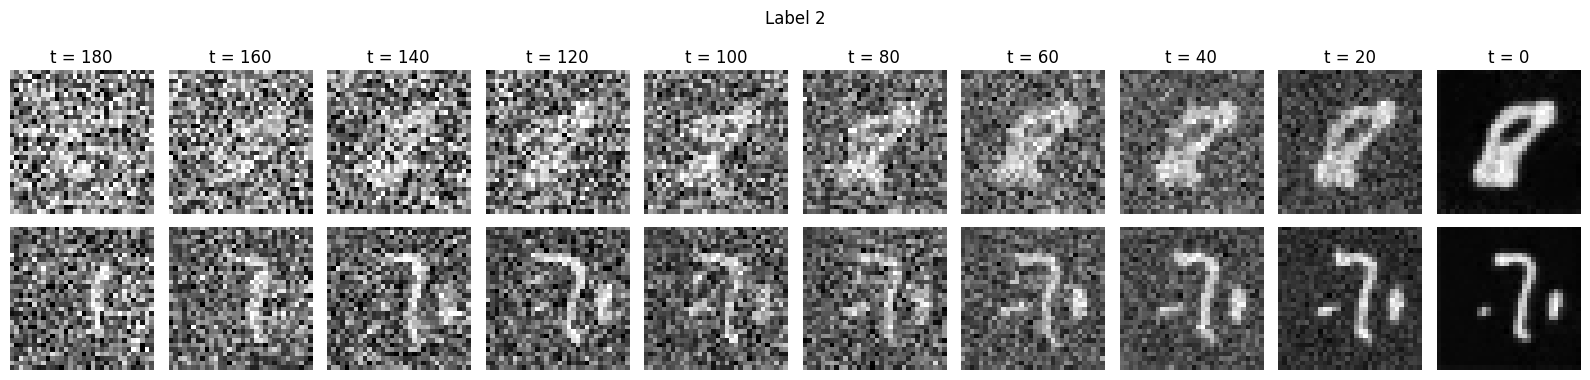

Epoch 14 | step 000 Loss: 0.06842629611492157 


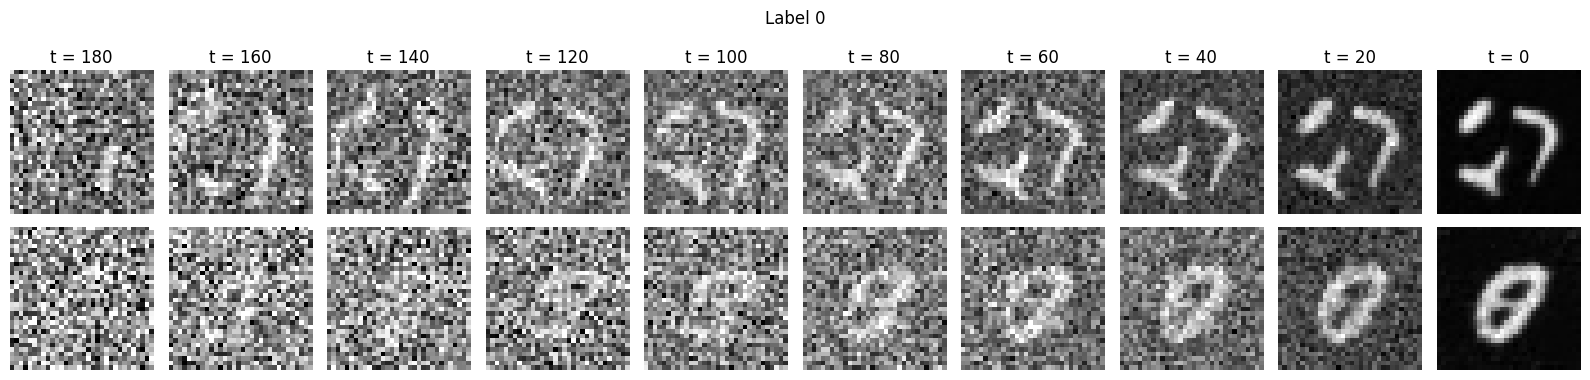

Epoch 15 | step 000 Loss: 0.08359482884407043 


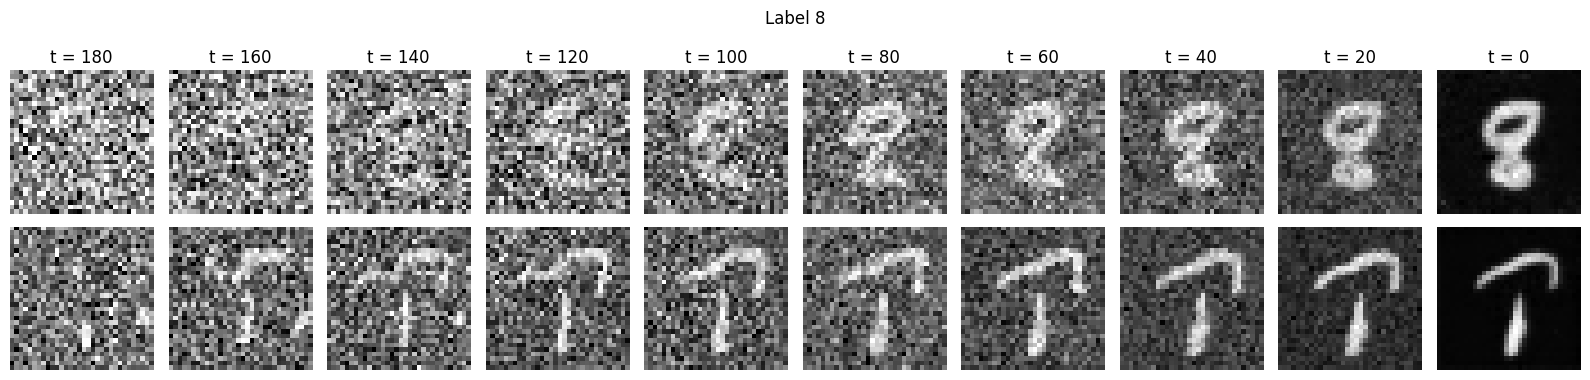

KeyboardInterrupt: 

In [15]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

loss_hist = []
batch_size = 32
device = "mps" if torch.backends.mps.is_available() else "cpu"

model = UNet(True)
model.to(device)

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.8)
iters = len(data) // batch_size
epochs = 100 
MSE = nn.L1Loss()

for epoch in range(epochs):
    for i in range(iters):
      optimizer.zero_grad()

      idx = torch.randint(0, len(data), (batch_size,))
      batch = data[idx].to(device)
      ybatch = y[idx].to(device)
      t = torch.randint(0, T, (batch_size, ), device=device)

      x_noise, noise = noisy_img(batch, t)
      noise_pred = model(x_noise , ybatch, t)

      loss = MSE(noise, noise_pred)
      loss_hist.append(loss.detach().clone().cpu().item())
      loss.backward()
      optimizer.step()

      if i % int(iters) == 0:
        scheduler.step()
        print(f"Epoch {epoch} | step {i:03d} Loss: {loss.item()} ")
        sample(model, size = 2)

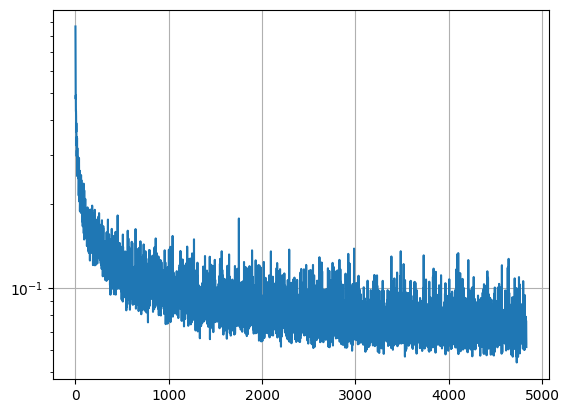

In [16]:
plt.plot(loss_hist)
plt.yscale('log')
plt.grid()
plt.show()

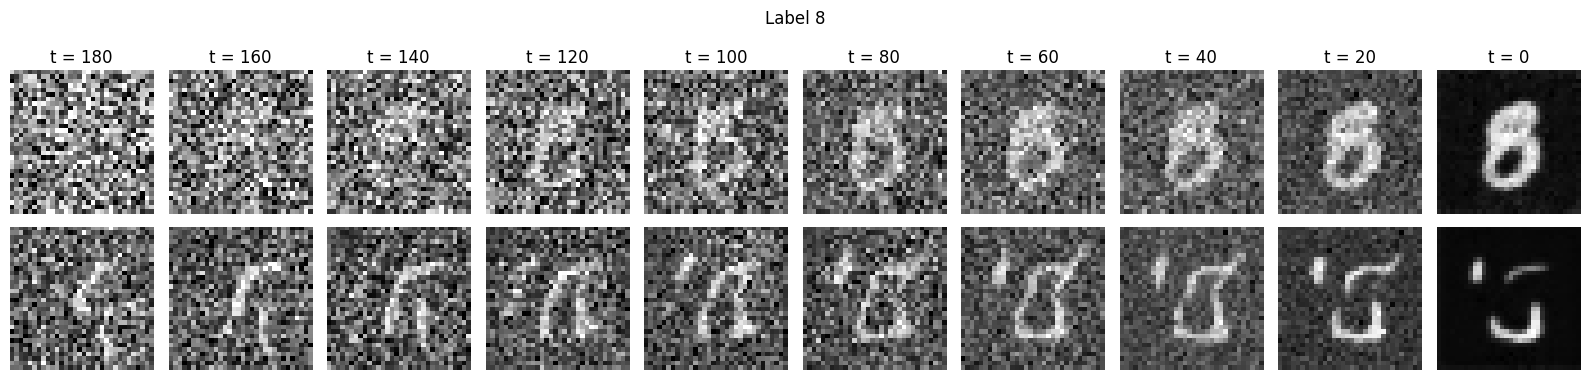

In [37]:
sample(model, size=2, label=8)